## 6.S083 / 18.S190
# PSET 1 Solution – Data Analysis


In [1]:
# import Pkg

# Pkg.add("CSV")
# Pkg.add("HTTP")
# Pkg.add("Plots")
# Pkg.add("Interact")
# Pkg.add("PlotlyJS")
# Pkg.add("DataFrames")
# Pkg.add("DataStructures")



## Exercise 1: Visualizing the data over time

------


In [2]:
using HTTP

case_csv = HTTP.get(
    "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
).body;


### 1. Extract the data and country names from the CSV file as we did in class

Call the country names `all_countries`


In [3]:
using CSV
using DataFrames

case_data = CSV.read(case_csv);

rename!(
  case_data,
  "Province/State" => "province",
  "Country/Region" => "country"
)

all_countries = unique(case_data.country);


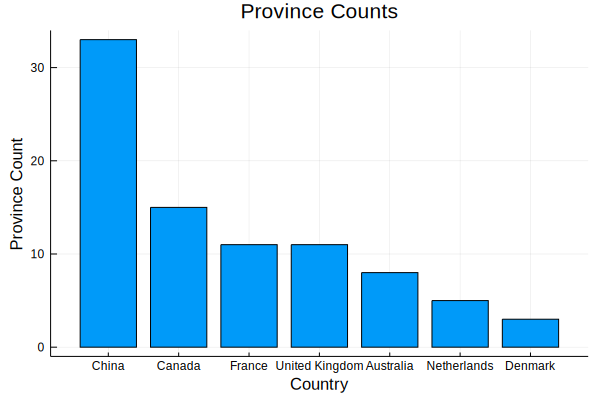

In [4]:
using Plots
using DataStructures

cur_counter = counter(case_data.country)

cur_counter = filter(
  cur_tuple -> cur_tuple[2] > 1, cur_counter
)

cur_counter = OrderedDict(
  reverse(sort(collect(cur_counter), by=x->x[2]))
)

bar(cur_counter, label="", title="Province Counts", ylabel="Province Count", xlabel="Country")



------

### 2. Make a `Vector` called `countries` with a subset of countries that we wish to plot 

Say China, Japan, South Korea, US, United Kingdom, France, Germany. Be careful to check how they are written in the data set


In [5]:
# note that "South Korea" => "Korea, South"

countries = sort([
  "China", "Japan", "Korea, South", "US", "United Kingdom", "France", "Germany"
])

country_data = case_data[map(cur_country -> cur_country in countries, case_data.country), :];


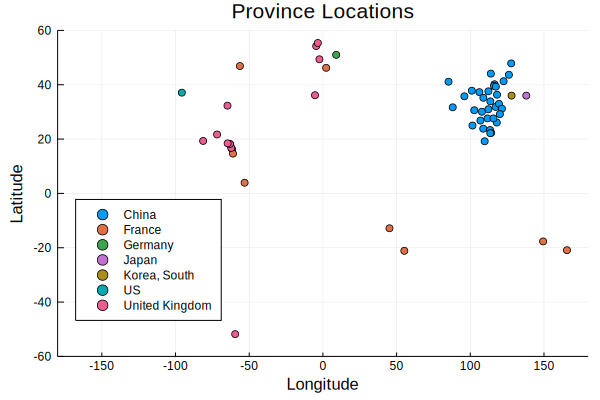

In [6]:
# note that France and UK include their colonies

scatter(
  country_data.Long, country_data.Lat, group=country_data.country, 
  legend=:bottomleft, xlims=(-180,+180), ylim=(-60,+60),
  xlabel="Longitude", ylabel="Latitude", title="Province Locations"
)


-----

### 3. Define a variable `num_days` by extracting the number of days of data from the dataframe.


In [7]:
using Dates

column_names = names(country_data)
day_columns = column_names[count.("/", map(string, column_names)) .== 2]

cur_dates = Date.(map(string, day_columns), DateFormat("m/d/y")) + Dates.Year(2000);
@show num_days = length(cur_dates);


num_days = length(cur_dates) = 77


-----

### 4. We need to accumulate the data for those places that are split up into territories. 

+ Make a zero vector of the correct length for each country, e.g. using the function `zeros`.

+ Loop through all the countries and add the corresponding data to that country's data.

+ You may use a dictionary (`Dict`), or a matrix, or a `Vector` containing `Vector`s, or a new `DataFrame` to store the data.


In [8]:
# data frame approach

aggregate_df = aggregate(
  groupby(
    country_data[:, [:country, day_columns...]], 
    :country
  ), 
  sum
)

# dict of lists approach

cur_dict = OrderedDict()
for country in countries
  cur_dict[country] = sum.(
    eachcol(country_data[country_data.country .== country, day_columns])
  )
end

# matrix approach

cur_matrix = zeros(Int, length(countries), num_days)
for (i, country) in enumerate(countries)
  sub_data = country_data[country_data.country .== country, day_columns]
  for cur_row in eachrow(sub_data)
    for j in 1:num_days
      cur_matrix[i,j] += cur_row[j]
    end
  end
end


-----

### 5. Plot all countries' data on the same graph by using a `for` loop.


Then run the loop, adding in the data using `plot!`

Finally, display the plot by evaluating the plot object `p`. (Just type its name and evaluate.)


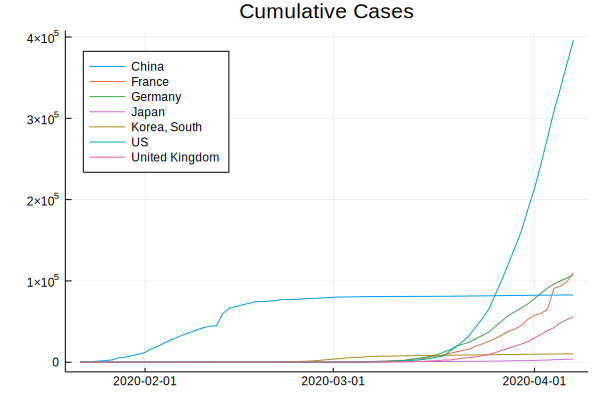

In [9]:
p = plot(legend=:topleft, title="Cumulative Cases")

for (country, cases) in cur_dict
  plot!(cur_dates, cases, label=country)
end

p


-----

### 6. Now use a `log` scale on the $y$ axis. 

In order to do so you will:

+ need to convert the vectors to contain `Float64` 
+ replace any 0 values by `NaN` ("not a number") so that `Plots.jl` ignores those values


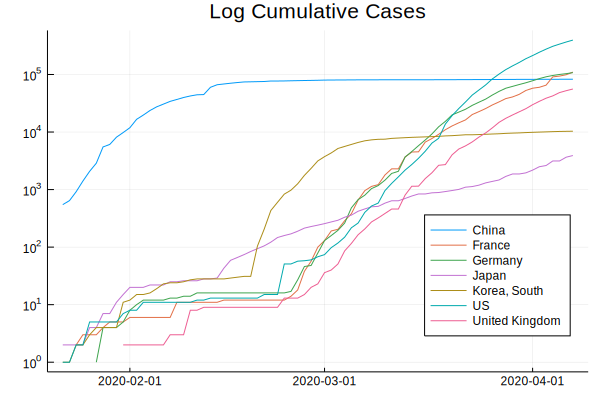

In [10]:
p = plot(legend=:bottomright, title="Log Cumulative Cases")

for (country, cases) in cur_dict
  plot!(cur_dates, replace(cases, 0 => NaN), label=country, yscale=:log10)
end

p


*Q: Is there exponential growth?*

***A: Yes there is exponential growth. After reaching 10 cases, most curves are approximately linear (or sigmoidal for South Korea)***

<br>

-----

### 7. Turn this into an interactive visualization by adding a slider corresponding to the current day

Varying the day between 1 and the total number of days for which you have data.

+ You should draw only the data up to that particular day. 
+ As you move the slider the plot should update. 
+ Fix the horizontal axis across slider changes

In [11]:
function custom_plot(yscale, cur_day)
  p = plot(legend=:bottomright, title="Cumulative Cases")

  for (country, cases) in cur_dict
    plot!(cur_dates[1:cur_day], replace(cases, 0 => NaN)[1:cur_day], label=country, markershape=:circle)
  end
  
  xlims!(map(Dates.value, (cur_dates[1], cur_dates[end])))
  ylims!(1, 2*maximum(Base.Iterators.flatten(values(cur_dict))))
  
  plot!(yscale=yscale)
end


custom_plot (generic function with 1 method)

In [12]:
using Interact

@manipulate for yscale=[:log10, :identity], cur_day in 1:num_days
  custom_plot(yscale, cur_day)
end


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-5245452998464726036\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-9159810793045086480\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-5245452998464726036\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["yscale"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :span), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text : key")))], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "click: function (){\$root.update(val)}, css: {'is-primary is-selected' : \$root.index() == val, 'interact-widget is-medium button ' : true}")))], Dict{Symbol,Any}(:attributes => ("data-bind" => "foreach : options_js"),:className => "buttons has-addons is-centered"))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol,Any}())], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("options_js" => (Observable{Any} with 1 listeners. Value:
OrderedDict[OrderedDict{String,Any}("key" => "log10","val" => 1,"id" => "id9Yp7lUIM"), OrderedDict{String,Any}("key" => "identity","val" => 2,"id" => "idPk1vXGYK")], nothing),"index" => (Observable{Any} with 2 listeners. Value:
1, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/dan/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/dan/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/dan/.julia/packages/InteractBase/NMcus/src/../assets/all.js"), Asset("css", nothing, "/Users/dan/.julia/packages/InteractBase/NMcus/src/../assets/style.css"), Asset("css", nothing, "/Users/dan/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("options_js" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"options_js\"]()) ? (this.valueFromJulia[\"options_js\"]=true, this.model[\"options_js\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000139cc4910, Task (runnable) @0x0000000139cc4910), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data 

----

## Exercise 2: Visualizing changes

Now let's try to reproduce the essence of the nice visualization from https://aatishb.com/covidtrends, which is a less usual point of view. 

+ Again the slider will represent a day during the epidemic.
+ The horizontal axis will show the *total* confirmed cases until the given day
+ While the vertical axis will show the *change* in confirmed cases during the past week (7 days).


In [13]:
function make_widget(cur_day, widget_dict=cur_dict, add_annotation=false)
  p = plot(
    legend=:topleft, xlabel="Total Cases", ylabel="Recent Cases", 
    title="COVID-19 Case Trajectory (" * string(day_columns[cur_day]) * ")",
    xscale=:log10, yscale=:log10
  )
  
  lims_dict = Dict(
    "min_x" => +Inf, "max_x" => -Inf,
    "min_y" => +Inf, "max_y" => -Inf,
  )
  
  for (cur_index, (country, cases)) in enumerate(deepcopy(widget_dict))
    cases = Array{AbstractFloat}(cases)
    
    recent_cases = make_recent_cases(cases)
    update_limits!(lims_dict, cases, recent_cases)

    cases = cases[1:cur_day]
    recent_cases =  recent_cases[1:cur_day]
    
    remove_small_values!(cases, recent_cases)
    isempty(cases) && continue

    plot!(cases, recent_cases, label=country, color=cur_index)
    
    add_annotation && add_annotations!(
      country, cur_index, cases[end], recent_cases[end]
    )
  end
  
  xlims!(lims_dict["min_x"]/2, lims_dict["max_x"]*2)
  ylims!(lims_dict["min_y"]/2, lims_dict["max_y"]*2)
end


make_widget (generic function with 3 methods)

In [14]:
function make_recent_cases(cases, delay=7) 
  return cases - [ zeros(Int, delay)..., cases[1:end-delay]... ]
end

function update_limits!(lims_dict, cases, recent_cases)
  for (tmp_key, tmp_cases) in Dict( :x => cases, :y => recent_cases )
    lims_dict["max_$(tmp_key)"] = max(lims_dict["max_$(tmp_key)"], maximum(tmp_cases))

    filter_cases = filter(!iszero, tmp_cases)
    if !isempty(filter_cases)
      lims_dict["min_$(tmp_key)"] = min(lims_dict["min_$(tmp_key)"], minimum(filter_cases)) 
    end
  end
end

function remove_small_values!(cases, recent_cases, min_cases=8, min_recent_cases=4)
  del_indices = []
  
  for (cur_cases, cur_threshold) in (cases => min_cases, recent_cases => min_recent_cases)
    append!(del_indices, findall(cur_case -> cur_case <= cur_threshold, cur_cases))
  end
  
  unique!(del_indices)
  sort!(del_indices)

  deleteat!(cases, del_indices)
  deleteat!(recent_cases, del_indices)
end


remove_small_values! (generic function with 3 methods)

In [15]:
@manipulate for cur_day in 1:num_days
  make_widget(cur_day)
end


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["cur_day"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 77,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
39, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/dan/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/dan/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/dan/.julia/packages/InteractBase/NMcus/src/../assets/all.js"), Asset("css", nothing, "/Users/dan/.julia/packages/InteractBase/NMcus/src/../assets/style.css"), Asset("css", nothing, "/Users/dan/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000113f13610, Task (runnable) @0x0000000113f13610), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\",\"37\",\"

----

### 1. Make a data set `total_cases`

Representing for each day the *total* number of confirmed cases during the whole epidemic up until that point


In [16]:
total_cases = sum.(eachcol(case_data[:, day_columns]));
# total_cases = sum.(eachcol(country_data[:, day_columns]));


----

### 2. Make a set of data `new_cases` which is the total number of cases only during the past 7 days.


In [17]:
new_cases = total_cases - [ zeros(Int, 7)..., total_cases[1:end-7]... ];
@assert make_recent_cases(total_cases) == new_cases

@assert true
# @assert false    # raises AssertionError


----

### 3. Make the visualization using a slider representing days as in the previous exercise

Plotting the total number of cases on the $x$ axis and new cases on the $y$ axis.

You need to take care that each vector being plotted has the same length.


In [18]:
all_dict = OrderedDict([
  ("All" => total_cases), 
  cur_dict...
])

@manipulate for cur_day in 1:num_days
  make_widget(cur_day, all_dict)
end


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["cur_day"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 77,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
39, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/dan/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/dan/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/dan/.julia/packages/InteractBase/NMcus/src/../assets/all.js"), Asset("css", nothing, "/Users/dan/.julia/packages/InteractBase/NMcus/src/../assets/style.css"), Asset("css", nothing, "/Users/dan/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000112ffead0, Task (runnable) @0x0000000112ffead0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\",\"37\",\"

----

### 4. Add a dot for each countries current position and annotate


In [19]:
# already used inside make_widget function

function add_annotations!(country, cur_index, cases_end, recent_cases_end)
  scatter!([cases_end], [recent_cases_end], label="", color=cur_index, markersize=2.5)
  annotate!(cases_end, recent_cases_end, text(country, 9, :grey, :left))
end


add_annotations! (generic function with 1 method)

In [20]:
@manipulate for cur_day in 1:num_days
  add_annotations = true
  
  make_widget(cur_day, all_dict, add_annotations)
end


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["cur_day"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 77,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
39, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/dan/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/dan/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/dan/.julia/packages/InteractBase/NMcus/src/../assets/all.js"), Asset("css", nothing, "/Users/dan/.julia/packages/InteractBase/NMcus/src/../assets/style.css"), Asset("css", nothing, "/Users/dan/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000001128fe410, Task (runnable) @0x00000001128fe410), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\",\"37\",\"

----

### 5. Make a GIF version of the plot from before



┌ Info: Saved animation to 
│   fn = /Users/dan/code/covid-19/notebooks/tmp.gif
└ @ Plots /Users/dan/.julia/packages/Plots/cc8wh/src/animation.jl:98


Plots.AnimatedGif("/Users/dan/code/covid-19/notebooks/tmp.gif")
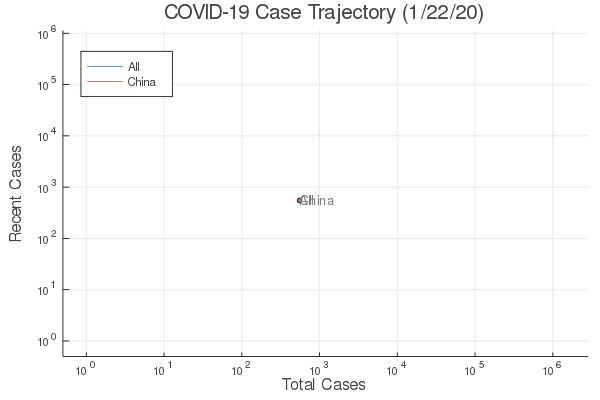

In [21]:
animation = @animate for cur_day in 1:num_days
  make_widget(cur_day, [("All" => total_cases), cur_dict...], true)
end

gif(animation, fps = 6)


----

## Extra Credit: Web Dashboard

In [22]:
# load file with custom plot extractor

include("dont_manipulate.jl")


compileTree (generic function with 2 methods)

In [23]:
plotlyjs()

@dont_manipulate "../docs/assets/json/confirmed-cases.json" for cur_day in 1:num_days, yscale=[:log10, :identity]
  custom_plot(yscale, cur_day)
end

IJulia.clear_output(true)

@dont_manipulate "../docs/assets/json/viral-trajectory.json" for cur_day in 1:num_days
  make_widget(cur_day, all_dict, true)
end

IJulia.clear_output(true)

gr()


Plots.GRBackend()